# MESQUAL 303: Interactive Geospatial `AreaKPIMapVisualizer` with Folium

This notebook demonstrates how to create interactive geospatial visualizations of electricity market data using the SegmentedColorMap module we explored in the previous notebook.

## Introduction

Geospatial visualization is one of the most effective ways to communicate regional patterns in electricity market data. In this notebook, we'll create a map showing:

1. Market prices by control area
2. Price increases between scenarios

We'll leverage our custom segmented colormaps to ensure clear visual differentiation between positive and negative values.

## Setup

First, we need to set up the environment. If you are on Colab, the first cell will clone and install all dependencies. You will have to restart the session afterwards and continue with cell 2. If you are in a local environment, make sure that you have followed the Getting started steps in the README, so that mesqual and all requirements are installed.

In [1]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import importlib.util

    def is_module_available(module_name):
        return importlib.util.find_spec(module_name) is not None

    if os.path.exists("mesqual-vanilla-studies") and is_module_available("mesqual"):
        print("✅ Environment already set up. Skipping installation.")
    else:
        print("🔧 Setting up Colab environment...")
        !git clone --recursive https://github.com/helgeesch/mesqual-vanilla-studies.git
        %cd mesqual-vanilla-studies/

        !pip install git+https://github.com/helgeesch/mesqual -U
        !pip install git+https://github.com/helgeesch/mesqual-pypsa -U
        !pip install git+https://github.com/helgeesch/captain-arro -U
        !pip install -r requirements.txt

        print('✅ Setup complete. 🔁 Restart the session, then skip this cell and continue with the next one.')
else:
    print("🖥️ Running locally. No setup needed.")

Running locally, let's continue.


In [2]:
import os

if "COLAB_RELEASE_TAG" in os.environ:
    import sys
    sys.path.append('/content/mesqual-vanilla-studies')
    os.chdir('/content/mesqual-vanilla-studies')
else:
    def setup_notebook_env():
        """Set working directory to repo root and ensure it's in sys.path."""
        import os
        import sys
        from pathlib import Path

        def find_repo_root(start_path: Path) -> Path:
            current = start_path.resolve()
            while current != current.parent:
                if (current / 'vanilla').exists():
                    return current
                current = current.parent
            raise FileNotFoundError(f"Repository root not found from: {start_path}")

        repo_root = find_repo_root(Path.cwd())
        os.chdir(repo_root)
        if str(repo_root) not in sys.path:
            sys.path.insert(0, str(repo_root))

    setup_notebook_env()

try:
    from mesqual import StudyManager
except ImportError:
    raise ImportError("❌ 'mesqual' not found. If you're running locally, make sure you've installed all dependencies as described in the README.")

if not os.path.isdir("studies"):
    raise RuntimeError(f"❌ 'studies' folder not found. Make sure your working directory is set to the mesqual-vanilla-studies root. Current working directory: {os.getcwd()}")

print("✅ Environment ready. Let’s go!")

✅ Environment ready. Let’s go!


In [3]:
import os
import folium

from mesqual import kpis
from mesqual.visualizations.value_mapping_system import SegmentedContinuousColorscale
from mesqual.visualizations.folium_legend_system import ContinuousColorscaleLegend
from mesqual.visualizations.folium_viz_system import (
    PropertyMapper, KPICollectionMapVisualizer,
    AreaFeatureResolver, AreaGenerator,
    TextOverlayFeatureResolver, TextOverlayGenerator,
)
from mesqual.utils.folium_utils.background_color import set_background_color_of_map
from mesqual.utils.plotly_utils.plotly_theme import colors
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook
from vanilla.conditional_renderer import ConditionalRenderer

configure_clean_output_for_jupyter_notebook()
renderer = ConditionalRenderer()

## Load Study Data

First, we load our study data which contains multiple scenarios of the German electricity system:


In [4]:
# Load the StudyManager with PyPSA Scigrid-DE network data we created in previous notebooks
from studies.study_01_intro_to_mesqual.scripts.setup_study_manager import get_scigrid_de_study_manager
study = get_scigrid_de_study_manager()

# Check available datasets
print("Available scenarios:")
for dataset in study.scen.datasets:
    print(f"- {dataset.name}")

Available scenarios:
- base
- solar_150
- solar_200
- wind_150
- wind_200


## Adding KPIs to Scenarios and Comparisons

To create our visualizations, we need to calculate relevant KPIs for each scenario and for the comparisons between scenarios:

In [5]:
# Clear any existing KPIs
study.scen.clear_kpi_collection_for_all_sub_datasets()
study.comp.clear_kpi_collection_for_all_sub_datasets()

# Initialize KPI lists
my_scen_kpis = []
my_comp_kpis = []

# Get base dataset to access control areas
ds_base = study.scen.get_dataset('base')

# Create volume-weighted market price KPIs for each control area
scen_kpis_market_price = [
    kpis.FlagAggKPIFactory(
        'control_areas_t.vol_weighted_marginal_price', # Time series flag
        aggregation=kpis.aggregations.Mean,            # Calculate mean across time
        column_subset=control_area                     # For each control area
    )
    for control_area in ds_base.fetch('control_areas').index.to_list()
]

# Add the price KPIs to our scenario KPIs list
my_scen_kpis += scen_kpis_market_price

# Create comparison KPIs to calculate price increases between scenarios
comp_vars_increase = [
    kpis.ComparisonKPIFactory(
        factory,                         # Use the same KPI factories as scenarios
        kpis.value_comparisons.Increase  # Calculate simple increase (var - ref)
    )
    for factory in my_scen_kpis
]

# Add the comparison KPIs to our comparison KPIs list
my_comp_kpis += comp_vars_increase

# Add all KPIs to respective datasets
study.scen.add_kpis_to_all_sub_datasets(my_scen_kpis)
study.comp.add_kpis_to_all_sub_datasets(my_comp_kpis)

# Compute all KPIs (with progress bar)
study.scen.get_merged_kpi_collection().compute_all()
study.comp.get_merged_kpi_collection().compute_all()

## Setting up the Map

Now we'll create a basic Folium map centered on Germany:

In [6]:
# Create a map centered on Germany
m = folium.Map(
    location=[51, 11],  # Center of Germany
    tiles=None,         # No background tiles initially
    zoom_start=6,       # Initial zoom level
    zoom_snap=0.25      # Allow finer zoom control
)

# Set a clean white background
m = set_background_color_of_map(m, color='#ffffff')

## Visualizing Market Prices by Control Area

Using our custom segmented colormap from the previous notebook, we'll create a visualization of market prices across Germany's control areas:

In [7]:
# Define the market price colormap legend (same as in mesqual_302)
price_segments = {
    (-500, -25): ['#000080'],               # Navy for extreme negative prices
    (-25, 0): ['#0000FF', '#87CEFA'],       # Blue to light blue for negative prices
    (0, 25): ['#00C300', '#FFFB00'],        # Light green to yellow for low positive prices
    (25, 500): ['#FFFB00', '#FF9300'],      # Yellow to orange for high positive prices
    (500, 10000): ['#FF0000']                # Red for extreme positive prices
}

price_colorscale = SegmentedContinuousColorscale(segments=price_segments)

# Add the colormap legend to the map
ContinuousColorscaleLegend(
    mapping=price_colorscale,
    title="Market Price (€/MWh)",
    width=350,
    padding=20,
    background_color="#FFFFFF",
    n_ticks_per_segment=2,
    position={'bottom': 20, 'right': 20}
).add_to(m)

# Create area KPI area_price_increase_visualizer with the colormap
area_generator = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_kpi_value(price_colorscale),
        fill_opacity=1,
        border_width=1.5,
        highlight_border_width=2.0,
    )
)

# Get KPI collection for scenarios
kpi_collection = study.scen.get_merged_kpi_collection()

# Generate feature groups for the map
KPICollectionMapVisualizer(
    generators=[
        area_generator,
        TextOverlayGenerator(),
    ],
).generate_and_add_feature_groups_to_map(kpi_collection, m)

KPICollectionMapVisualizer: 100%|██████████| 20/20 [00:00<00:00, 515.44it/s]


## Visualizing Price Increases Between Scenarios

Next, we'll add another layer showing the price differences between scenarios:

In [8]:
# Define a new colormap for price increases
price_increase_colorscale = SegmentedContinuousColorscale(
    segments={
        (0, 10): colors.sequential.shades_of_pink,    # Pink for price increases
        (-10, 0): colors.sequential.shades_of_cyan[::-1],  # Cyan for price decreases
    },
    nan_fallback='#A2A2A2',  # Grey for NA values
)

# Add the second colormap legend to the map
ContinuousColorscaleLegend(
    mapping=price_increase_colorscale,
    title='Price Increase (Vol Weighted) [€/MWh]',
    background_color='white',
    width=350,
    position=dict(bottom=150, right=20),  # Position below the first legend
    padding=20,
).add_to(m)

# Create a new area_price_increase_visualizer for comparison data
area_price_increase_visualizer = AreaGenerator(
    AreaFeatureResolver(
        fill_color=PropertyMapper.from_kpi_value(price_increase_colorscale),
        border_width=1.5,
        highlight_border_width=1.5,
        fill_opacity=1.0,
    ),
)

# Filter KPI collection to include only "Increase" values
kpi_collection = study.comp.get_merged_kpi_collection().get_filtered_kpi_collection_by_attributes(
    value_operation='Increase'
)

# Generate feature groups for comparisons
KPICollectionMapVisualizer(
    generators=[
        area_price_increase_visualizer,
        TextOverlayGenerator(),
    ]
).generate_and_add_feature_groups_to_map(kpi_collection, m, show='last')

KPICollectionMapVisualizer: 100%|██████████| 16/16 [00:00<00:00, 264.30it/s]


## Adding Layer Controls and Finalizing the Map

Finally, we'll add layer controls so users can toggle between different visualizations:

In [9]:
# Add layer controls
folium.LayerControl(collapsed=False, draggable=True).add_to(m)

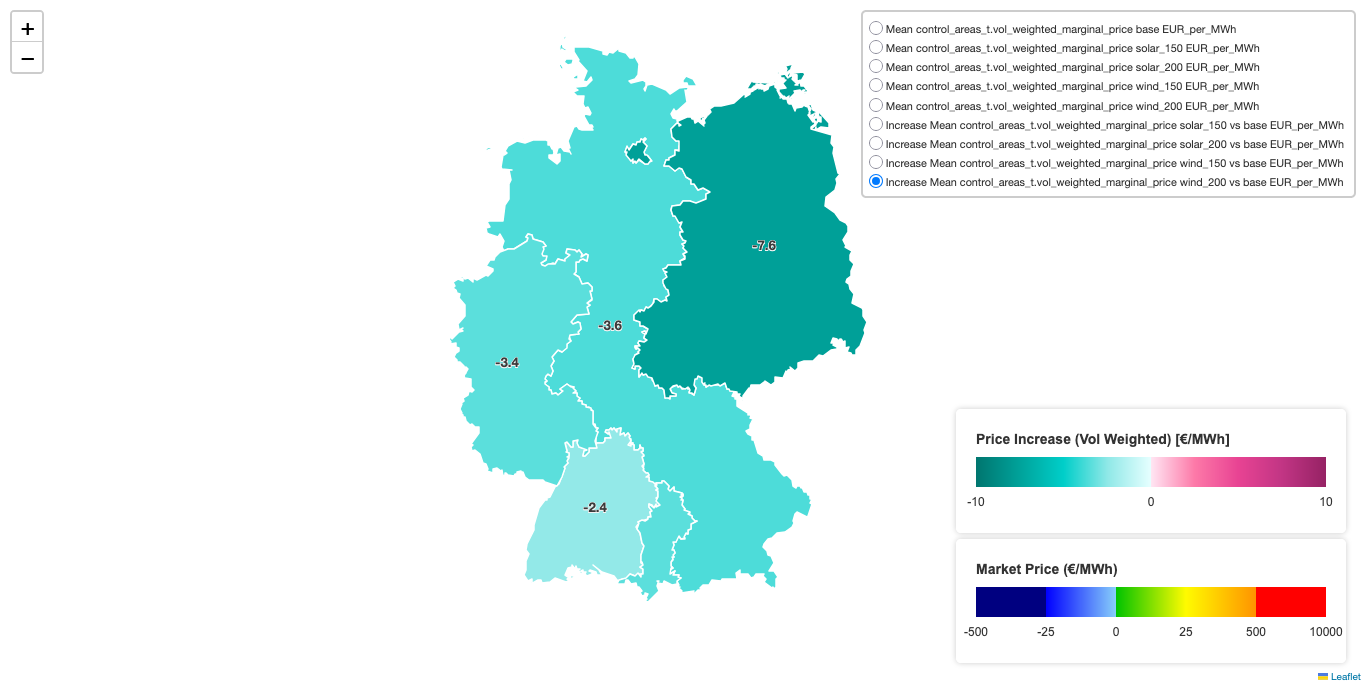

In [10]:
renderer.show_folium(m)

## What do we see?
If you are watching the static image in the Jupyter Notebook, it is showing the "Price Increase" for the last scenario-comparison in the study (wind_200 vs base).
Since all values are negative, we know that the increase to 200% wind lead to a price decrease in all control_areas, with the highest price reduction in 50Hertz control_area (North-East), and the smallest reduction in the EnBW control area (South-West).

If you open the interactive version (either through showing m in the notebook, or by saving the map as an html and opening it in the browser), you can select the FeatureGroup in the map's menu on the top right and select the dataset (comparison) and indicator you want to project on the map. Besides projecting the "Price Increase" for each scenario-comparison, you can also show the "Market Price" per single scenario.

## Conclusion

In this notebook, we've demonstrated how to create advanced geospatial visualizations of electricity market data using Folium and our custom SegmentedColorMap module. The key advantages of this approach are:

1. **Clear visual differentiation** between positive and negative values
2. **Multiple map layers** for different types of analysis (absolute prices and price changes)
3. **Custom legends** that help interpret the data
4. **Interactive features** like hover tooltips and layer toggling

These techniques can be applied to any geospatial electricity market data, allowing for intuitive visualization of complex market dynamics across regions.

In the next notebook, we'll explore how to create animated visualizations to show temporal patterns in market data.